In [1]:
%matplotlib inline
%load_ext line_profiler
%load_ext memory_profiler

In [2]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import pycrfsuite as crf

from itertools import chain
from collections import defaultdict

from sklearn.preprocessing import LabelBinarizer

from sqlearn.crfsuite import crfutils
from sqlearn.crfsuite import ner

In [3]:
#%%writefile load_data.py
#%%prun -s cumulative -q -l 10 -T prun0

import numpy as np

from sqlearn.crfsuite import crfutils
from sqlearn.crfsuite import ner

s = """
ner.templates = (
 (('w', -2),),
 (('w', -1),),
 (('w', 0),),
 (('w', 1),),
 (('w', 2),),
 (('w', -2), ('w', -1)),
 (('w', -1), ('w', 0)),
 (('w', 0), ('w', 1)),
 (('w', 1), ('w', 2)),
 (('pos', -2),),
 (('pos', -1),),
 (('pos', 0),),
 (('pos', 1),),
 (('pos', 2),),
 (('pos', -2), ('pos', -1)),
 (('pos', -1), ('pos', 0)),
 (('pos', 0), ('pos', 1)),
 (('pos', 1), ('pos', 2)),
 (('pos', 2), ('pos', 3)),
 (('pos', -2), ('pos', -1), ('pos', 0)),
 (('pos', -1), ('pos', 0), ('pos', 1)),
 (('pos', 0), ('pos', 1), ('pos', 2))
)
"""

def load_data(f):
    X = []
    y = []
    sent = []
    sent_label = []
    for line in open(f, 'r'):
        line = line.strip('\n')
        if line.strip() == '':
            sent.append('\n')
            for item in crfutils.readiter(sent, ['w', 'pos'], ' '):
                ner.feature_extractor(item)
                X.append(item)
                y.append(sent_label)
            sent = []
            sent_label = []
        else:
            splited_line = line.split(' ')
            sent.append('%s %s' % (splited_line[0], splited_line[1]))
            sent_label.append(splited_line[2])

    X = [[feature['F'] for feature in sent] for sent in X]

    X = np.asarray(X)
    y = np.asarray(y)

    print(len(X))
    print(len(y))
    
    return X, y

In [4]:
%%time
X, y = load_data('data.conll')

CPU times: user 7 µs, sys: 3 µs, total: 10 µs
Wall time: 21.9 µs
504
504


In [14]:
%%writefile prof.py
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import pycrfsuite as crf

from itertools import chain
from collections import defaultdict

from sklearn import cross_validation
from sklearn.preprocessing import LabelBinarizer
    
def error_score(y_true, y_pred):
    lb = LabelBinarizer()
    y_true_combined = lb.fit_transform(list(chain.from_iterable(y_true)))
    y_pred_combined = lb.transform(list(chain.from_iterable(y_pred)))

    tagset = set(lb.classes_) - {'O'}
    tagset = sorted(tagset, key=lambda tag: tag.split('-', 1)[::-1])
    class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}
    
    y_acc_eval_array = y_true_combined + y_pred_combined
    error_score = {item[0]: 1 - sum(y_acc_eval_array[:, item[1]] == 2)/sum(y_acc_eval_array[:, item[1]] > 0) for item in class_indices.items()}
    
    return error_score

def measure(data_size, X, y):
    train_errors = defaultdict(list)
    test_errors = defaultdict(list)
    
    ss = cross_validation.ShuffleSplit(data_size, n_iter=5, test_size=.20, random_state=0)
    
    for fold_idx, (train_index, test_index) in enumerate(ss):
        print('Iteration #%i' % fold_idx)
        
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]

        # train
        model_name = 'm%i.crfsuite' % fold_idx
        trainer = crf.Trainer(verbose=False)
        trainer.set_params({
            'c1': 1.0,   # coefficient for L1 penalty
            'c2': 1e-3,  # coefficient for L2 penalty
            'max_iterations': 50,  # stop earlier
            'num_memories': 3,
            
            # include transitions that are possible, but not observed
            'feature.possible_transitions': True
        })
        
        Xy = zip(X_train, y_train)
        for xseq, yseq in Xy:
            trainer.append(xseq, yseq)
        trainer.train(model_name)
        trainer.clear()
        
        # predict
        tagger = crf.Tagger()
        tagger.open(model_name)
        y_train_pred = [tagger.tag(xseq) for xseq in X_train]
        y_test_pred  = [tagger.tag(xseq) for xseq in X_test]
        tagger.close()
        
        # evaluate
        train_error = error_score(y_train, y_train_pred)
        test_error = error_score(y_test, y_test_pred)
        
        map(lambda item: train_errors[item[0]].append(item[1]), train_error.items())
        map(lambda item: test_errors[item[0]].append(item[1]), test_error.items())

        del trainer
        del tagger
        
        del Xy
        del y_train_pred
        del y_test_pred
        del X_train
        del y_train
        del X_test
        del y_test
        del train_index
        del test_index
        
    return {item[0]: np.mean(item[1]) for item in train_errors.items()}, {item[0]: np.mean(item[1]) for item in test_errors.items()}

def bias_variance(X, y, start, stop, step):
    data_sizes = np.arange(start, stop, step)
    train_errors = defaultdict(list)
    test_errors = defaultdict(list)

    for data_size in data_sizes:
        print('Size %i' % data_size)
        train_error, test_error = measure(data_size, X, y)

        map(lambda item: train_errors[item[0]].append(item[1]), train_error.items())
        map(lambda item: test_errors[item[0]].append(item[1]), test_error.items())
    
    return data_sizes, train_errors, test_errors

Writing cv.py


In [ ]:
# Run Profiler
import prof
reload(prof)
#%lprun -T lprof1 -f prof.measure prof.measure(60, X, y)
#%mprun -T mprof1 -f prof.measure prof.measure(60, X, y)
%mprun -T mprof1 -f prof.bias_variance prof.bias_variance(X, y, 100, 501, 10)

Size 100
Iteration #0
Iteration #1
Iteration #2
Iteration #3
Iteration #4
Size 110
Iteration #0
Iteration #1
Iteration #2
Iteration #3
Iteration #4


In [ ]:
data_sizes, train_errors, test_errors = prof.bias_variance(X, y, 100, 501, 10)

In [24]:
def plot_bias_variance(data_sizes, train_errors, test_errors, tags):
    plt.figure(num=None, figsize=(6, 5))
    plt.ylim([0.0, 1.0])
    plt.xlabel('Data set size')
    plt.ylabel('Error')
    plt.title("Bias-Variance")
    map(lambda tag: plt.plot(data_sizes, train_errors[tag], data_sizes, test_errors[tag], lw=1), tags)
    plt.legend(list(chain.from_iterable([['%s test error' % tag, '%s train error' % tags] for tag in tags])), loc="upper right")
    plt.grid(True, linestyle='-', color='0.75')
    plt.show()

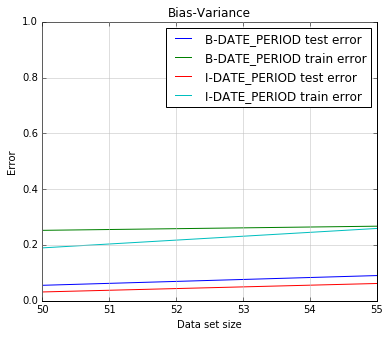

In [30]:
plot_bias_variance(data_sizes, train_errors, test_errors, tags=['B-DATE_PERIOD', 'I-DATE_PERIOD'])